In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Geochemical Facies Analysis using Machine Learning

**Brendon Hall, Enthought**

This tutorial will demonstrate step-by-step how to build a practical geoscience machine learning workflow using Python and scikit-learn. The practice of extracting insights from large datasets has certainly caught mainstream attention in recent years. Software packages are emerging with multivariate and machine learning algorithms built in to workflows.  As this trend continues, it is important to understand how these algorithms work, know their strengths and limitations, and avoid treating them as a black box.   

Python has become a popular programming language for scientific applications as it is straightforward to learn, has a large community of users and contributors that have created many open (and free) scientific libraries.  The `scikit-learn` (http://scikit-learn.org/stable/)[http://scikit-learn.org/stable/] library provides a state-of-the-art collection of machine learning tools for Python and contains many tools for data mining and analysis including classification, clustering, and regression algorithms. 

In this tutorial, we demonstrate how dimensionality reduction and unsupervised machine learning can be used to analyze X-ray fluorescence measurements of cuttings samples. Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a smaller set of features that describe most of the variation within the dataset. Clustering is an unsupervised machine learning technique that learns a grouping from the data itself and doesn't require training data. The groups consist of samples with similar characteristics, which can be considered as distinct geochemical facies. This will be implemented using Python, the scikit-learn library (Pedregosa et al. 2011) and other popular Python data science tools.  These tools are open source and available online.  Enthought’s Canopy provides an easy to use interface to install these packages (and many more), as well as an integrated analysis and visualization environment.  It is available for free at [www.enthought.com/product/canopy](www.enthought.com/product/canopy/).

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

# Machine learning libraries

from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans

# Visualization libraries
import matplotlib.pylab as plt
import seaborn as sns

# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
pd.set_option("max_r",6)
pd.set_option("display.max_columns", 6)

In [3]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## XRF Cuttings Analysis

X-ray fluorescence (XRF) is becoming a common wellsite cuttings analysis technique (Carr et al, 2014). Portable XRF provides rapid elemental composition measurements of cuttings as they are drilled. These devices measure the fluorescent X-rays emitted by a sample when illuminated by an energetic X-ray source. Elements in the sample will emit X-rays at specific wavelengths, and the spectrum of the emitted X-rays can be measured and used to quantify the amount of the corresponding elements present in the sample. Trends in element concentration can be used to infer sediment depositional environment, sources, and indicate conditions conducive to the preservation of organic material. XRF data can be used for geologic characterization, optimizing well placement, and providing additional guidance for geosteering.

The data for this tutorial consists of XRF measurements of cuttings from the lateral section of an unconventional well. The measurements were made at approximately 10 m intervals. In this case, the raw data consists of 22 measurements for each sample. Each measurement gives the weight percentage of a chemical component. The data is read from a `csv` file into a dataframe using the [`pandas`](https://pandas.pydata.org/) library, which provides many convenient data structures and tools for data science. 

A dataframe is a 2-dimensional labeled data structure, where each row represents a different sample, and the columns are measurements on the sample.  The contents of the dataframe are shown in Table 1.

In [4]:
import pandas as pd
geochem_df = pd.read_csv('XRF_dataset.csv')
geochem_df

,Well Name,Depth,Quartz,...,SO3,Cl,Zr
0,Well 1,3173.97,27.56,...,1.20,0.28,201.70
1,Well 1,3183.11,42.92,...,0.81,0.26,395.35
2,Well 1,3192.26,44.55,...,0.76,0.23,362.70
...,...,...,...,...,...,...,...
266,Well 1,6255.50,45.04,...,0.97,0.02,337.37
267,Well 1,6273.78,41.21,...,1.05,0.02,356.98
268,Well 1,6296.64,46.72,...,0.77,0.02,360.96


## Feature Engineering

In machine learning, the term *feature* is used to refer to the attributes of the objects being considered that can be used to describe, cluster, and classify them. In this case, the objects being studied are cuttings samples, and the features are the 22 XRF measurements. We can use *feature engineering* to augment this dataset. This refers to the process of using domain knowledge to create new features that help machine learning algorithms discriminate the data.

In geochemistry, elements are used as proxies that give hints to the physical, chemical or biological events that were occurring during rock formation. Ratios of certain elements can indicate the relative strength of various effects. We will focus on three ratios: Si/Zr, Si/Al, and Zr/Al. The Si/Zr ratio is used to indicate relative proportions of biogenic silica and terrestrial detrital inputs and the Si/Al ratio is used as a proxy for biogenic silica to aluminous clay (Croudace and Rothwell, 2015). The Zr/Al ratio is a proxy for terrigenous input; chemical behavior of Zr suggests that this ratio can be used as a proxy for grain size (Calvert and Pederson, 2007).


In [5]:
geochem_df['Si/Zr'] = geochem_df['SiO2'] / geochem_df['Zr']
geochem_df['Si/Al'] = geochem_df['SiO2'] / geochem_df['Al2O3']
geochem_df['Zr/Al'] = geochem_df['Zr'] / geochem_df['Al2O3']

In [6]:
geochem_df.columns

Index(['Well Name', 'Depth', 'Quartz', 'K-Feldspar', 'Plagioclase', 'Chlorite',
       'IlliteSmectiteMica', 'Calcite', 'Ankerite/Dolomite', 'Pyrite',
       'Organics', 'Al2O3', 'SiO2', 'TiO2', 'Fe2O3', 'MnO', 'MgO', 'CaO',
       'Na2O', 'K2O', 'P2O5', 'SO3', 'Cl', 'Zr', 'Si/Zr', 'Si/Al', 'Zr/Al'],
      dtype='object')

## Dimensionality Reduction

Not surprisingly, multivariate datasets contain plenty of variables. This richness can be used to explain complex behaviour that can't be captured with a single observation. Multivariate methods allow us to consider changes in several observations simultaneously. With many observations, it is quite likely that the changes we observe are related to a smaller number of underlying causes. Dimensionality reduction is the process of using the correlations in the observed data to reveal a more parsimonious underlying model that explains the observed variation.

Exploratory factor analysis (EFA) reduces the number of variables by identifying the underlying *latent factors* present in the dataset. These factors cannot be measured directly; they can be determined only by measuring manifest properties. For example, in the case of our geochemical dataset, a shaliness factor could be associated with high silicon dioxide, calcium and quartz readings.  EFA assumes that the observations are a linear combination of the underlying factors, plus some Gaussian noise (Hauck, 2014). A related dimensionality reduction technique is principal component analysis (PCA). PCA determines components that are weighted linear combinations of the observations and makes the assumption that the components themselves account for the all of the observed variance in the data; none of the variance is caused by error (or noise).  EFA assumes that there is variance due to error (Rietveld and Van Hout, 1993).

Before applying EFA, the features should be rescaled by standardization. This involves rescaling each feature in the dataset to have zero mean and unit variance. This is necessary for many machine learning algorithms. Consider the case where measurements were made using different scales; one component varies between 10 and 300 [ppm] and another varies between 0.1 and 0.3 [wt%]. The variation in the former seems 1000 times greater than the latter if we don’t account for the scale. This will skew the factor analysis and the weights assigned to each factor. The preprocessing module in the scikit-learn library has tools for rescaling the dataset.

In [9]:
from sklearn.preprocessing import scale
data = geochem_df.iloc[:, 2:]
data = scale(data)

EFA requires that the number of factors to be extracted is specified *a priori*. Often, it is not immediately obvious how many factors should be specified. Many authors have proposed rules over the years (e.g., Preacher et al, 2013). One simple approach (known as the Kaiser criterion) involves looking at eigenvalues of the data’s covariance matrix and counting the number above a threshold value (typically 1.0).   The following code snippet will compute and plot the eigenvalues.  

In [ ]:
f

In [ ]:
np.shape(data)

In [7]:
fig = plt.figure(figsize=(10,6))
covar_matrix = np.cov(data, rowvar=False)
eigenvalues = np.linalg.eig(covar_matrix)[0]
plt.plot(eigenvalues, 'o-')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.tick_params(labelsize=18)
plt.xlabel('Eigenvalue Index', fontsize=24)
plt.ylabel('Magnitude', fontsize=24)
# fig.savefig('images/Figure_1_eigs.tif', dpi=300, bbox_inches='tight')
# fig.savefig('images/Figure_1_eigs.png', dpi=300, bbox_inches='tight')

NameError: name 'data' is not defined

<Figure size 720x432 with 0 Axes>

The `scikit-learn` library contains a factor analysis module that can be used to extract the 6 factors. This is done by creating a factor analysis model and fitting the model to the data.

In [ ]:
fa_model = FactorAnalysis(n_components = 6)
fa_model.fit(data)
factor_data = fa_model.transform(data)

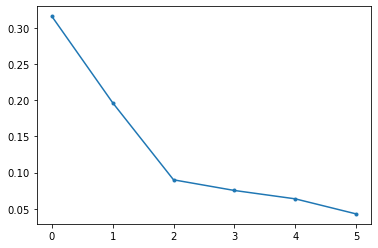

In [10]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=6)
pca_model.fit(data)
pca_data=pca_model.transform(data)
plt.plot(pca_model.explained_variance_ratio_,'.-')

In [ ]:
# create a dataframe consisting of the factor values for each data point
factor_df = pd.DataFrame(factor_data, columns=['Comp {}'.format(i) for i in range(0,3)])
factor_df['Well Name'] = geochem_df['Well Name']
factor_df['Depth'] = geochem_df['Depth']

# create a dataframe with the factor loadings associated with each observation
loading = fa_model.components_
component_names = geochem_df.columns.values[2:]
loading_df =  pd.DataFrame(loading,
                           columns=component_names)

In [11]:
# create a dataframe consisting of the factor values for each data point
pca_df = pd.DataFrame(pca_data, columns=['Comp {}'.format(i) for i in range(0,6)])
pca_df['Well Name'] = geochem_df['Well Name']
pca_df['Depth'] = geochem_df['Depth']

# create a dataframe with the factor loadings associated with each observation
loading = pca_model.components_
component_names = geochem_df.columns.values[2:]
loading_df =  pd.DataFrame(loading,columns=component_names)

### Interpreting the factors

The factors can now be examined to interpret the underlying properties they represent. The *factor loadings* describe the relationship of each measurement to the underlying factor.   Each loading score represents the correlation between the factor and the observed variables.  The loading scores vary between -1 and 1. A positive value means that a measurement is associated with the presence of an underlying factor.  A negative value suggests that a measurement indicates the absence of a factor.   The factor loadings can be easily extracted from the factor model, and plotted to show the loadings associated with a given factor.

Figure 2 (below) shows the factor loadings associated with the fifth factor.  In this case, the factor is associated with high values of plagioclase, illite/smectite/mica, pyrite, and organic material, and the absence of calcite and MgO.  We could interpret this factor as the organic-rich clay content. Similar interpretations can be given to the other factors by observing their loading scores.

In [ ]:
factor_df
factor_df['Comp 0']

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(_df['Comp 0'],factor_df['Comp 1'],factor_df['Comp 2'])

In [12]:
for factor_id in range(0, loading_df.shape[0]):

    # just plot the fourth factor, remove the loop to plot all
    if factor_id == 6:
        fig = plt.figure(figsize=(10,4))
        #plt.title('Factor {}'.format(factor_id))
        plt.ylabel('Factor loadings', fontsize=24)
        loading_df.iloc[factor_id].plot(kind='bar')
        plt.tick_params(labelsize=20)
        # fig.savefig('images/Figure_2_Factor_interp.png', dpi=300, bbox_inches='tight')
        # fig.savefig('images/Figure_2_Factor_interp.tif', dpi=300, bbox_inches='tight')
        break
    else:
        continue

## Clustering
   
The factor analysis has reduced the initial collection of 25 XRF features to a set of 6 underlying factors. A logical next step would be using these factors to group the cuttings samples by their common geochemical traits.  These groups can be interpreted to represent *geochemical facies*. Cluster analysis is a suitable approach for assigning a common facies label to similar samples. Clustering attempts to group samples so that those in the same group (or cluster) are more similar than those in other clusters. Cluster analysis is one class of techniques that fall under the category of *unsupervised* machine learning. These approaches are used to infer structure from the data itself, without the use of labeled training data to guide the model. 

The [K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)  algorithm clusters data by trying to separate samples into $k$ groups of equal variance. The algorithm locates the optimal cluster centroids by minimizing the distance between each point in a cluster and the closest centroid. The algorithm has three steps. It initializes by picking locations for the initial $k$ centroids (often random samples from the dataset). Next, each sample is assigned to one of the $k$ groups according to the nearest centroid. New centroids are then calculated by finding the mean values of each sample in each group. This is repeated until the difference between subsequent centroid positions falls below a given threshold.

Similar to EFA, K-Means requires that the number of clusters is specified before running the algorithm. There are a number of approaches to finding the optimal number of clusters. The goal is to choose the minimum number of clusters that accurately partition the dataset. These range from the relatively simple 'elbow method' to more rigorous techniques involving the Bayesian information criterion and optimizing the Gaussian nature of each cluster (Hamerly and Elkan, 2003). The following code demonstrates the 'elbow method' applied to this dataset. The sum of the squared distance of each point to the nearest cluster centroid (called *inertia* in `scikit-learn`) is plotted for an increasing number of clusters. As the number of clusters is increased and better fit the data, error is decreased. The elbow of the curve represents the point of diminishing returns where increasing the number of clusters does not reduce the error appreciably. Figure 3 (below) suggests that about 6 clusters would be adequate for this dataset.

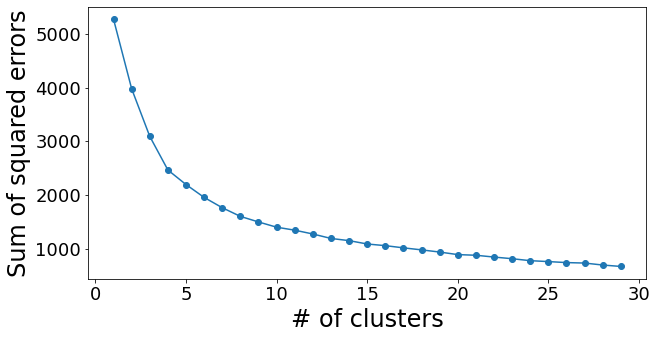

In [13]:
inertias = []
means = []
maxK = 30
for k in range(1, maxK):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_data)
    means.append(k)
    inertias.append(kmeans.inertia_)

fig = plt.figure(figsize=(10,5))
plt.plot(means, inertias, 'o-')
plt.xlabel('# of clusters', fontsize=24)
plt.ylabel('Sum of squared errors', fontsize=24)
plt.tick_params(labelsize=18)
# fig.savefig('images/Figure_3_k_means.tif', dpi=300, bbox_inches='tight')
# fig.savefig('images/Figure_3_k_means.png', dpi=300, bbox_inches='tight')

The K-means algorithm in `scikit-learn` is used to cluster the reduced dataset.  Similar to the factor analysis, this is done by creating a K-means model and fitting the factor dataset.

In [14]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(factor_data)

# add the cluster ids to the dataset
factor_df['Cluster'] = kmeans.labels_ + 1
geochem_df['Cluster'] = kmeans.labels_

NameError: name 'factor_data' is not defined

### Interpreting the clusters

Each sample in the dataset has now been assigned to one of six clusters.  If we are going  to interpret these clusters as geochemical facies, it is useful to inspect the to inspect the geochemical signature of each cluster. Figure 4 (below) contains a series of box plots that show the distribution of a small subset of measurements across each of the 6 clusters.  Box plots depict 5 descriptive statistics; the horizontal lines of the colored rectangle show the first quartile, median and third quartile.  The arms show the minimum and maximum.  Outliers are shown as black diamonds.  This plot is generated using the statistical visualization library `seaborn` [https://seaborn.pydata.org/](https://seaborn.pydata.org/).

Figure 4A indicates that Cluster 2 is characterized by a relatively high (and variable) Si/Zr ratio.  Cluster 4 has a high Zr/Al ratio (4B, 4C) and cluster 3 has a high MgO signature.  This can be done for each measurement to build up a geologic interpretation of each cluster.  

In [ ]:
facies_colors = sns.color_palette("Set2", 6)

fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
b= sns.boxplot(x='Cluster', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
b.set_title("A",fontsize=24)
b.set_xlabel("")
b.set_ylabel("Illite/Smectite/Mica [Wt%]",fontsize=24)
b.tick_params(labelsize=14)

b= sns.boxplot(x='Cluster', y='Organics', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
b.set_title("B",fontsize=24)
b.set_xlabel("")
b.set_ylabel("Organics [Wt%]",fontsize=24)
b.tick_params(labelsize=18)

b=sns.boxplot(x='Cluster', y='Calcite', linewidth=0.5,
            data=geochem_df, ax=ax[1,0],
            palette=facies_colors)
b.set_title("C",fontsize=24)
b.set_xlabel("Cluster Index",fontsize=24)
b.set_ylabel("Calcite [Wt%]",fontsize=24)
b.tick_params(labelsize=14)

b=sns.boxplot(x='Cluster', y='MgO', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)
b.set_title("D",fontsize=24)
b.set_xlabel("Cluster Index",fontsize=24)
b.set_ylabel("MgO [Wt%]",fontsize=24)
b.tick_params(labelsize=18)

plt.tight_layout()
# fig.savefig('images/Figure_4_Cluster_fingerprint.png', dpi=300, bbox_inches='tight')
# fig.savefig('images/Figure_4_Cluster_fingerprint.tif', dpi=300, bbox_inches='tight')

In [ ]:
def make_facies_log_plot(logs, facies_colors, label):
    # reset to original matplotlib style
    # seaborn doesn't look as good for this
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    #make sure logs are sorted by depth 
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 10))
    ax[0].plot(logs['IlliteSmectiteMica'], logs.Depth, '-g')
    ax[1].plot(logs['Organics'], logs.Depth, '-')
    ax[2].plot(logs['Calcite'], logs.Depth, '-', color='0.5')
    ax[3].plot(logs['MgO'], logs.Depth, '-', color='r')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((10*' ').join(['Clust 1', 'Clust 2', 'Clust 3', 
                                'Clust 4', 'Clust 5', 'Clust 6']), fontsize=14)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel('Clay Minerals', fontsize=16)
    ax[0].set_xlim(logs['IlliteSmectiteMica'].min(),logs['IlliteSmectiteMica'].max())
    ax[0].set_ylabel('MD [m]', fontsize=24)
    ax[0].tick_params(labelsize=12)
    ax[0].grid(b=False)
    ax[1].set_xlabel("Organics", fontsize=16)
    ax[1].set_xlim(logs['Organics'].min(),logs['Organics'].max())
    ax[1].grid(b=False)
    ax[1].tick_params(labelsize=12)
    ax[2].set_xlabel("Calcite", fontsize=16)
    ax[2].set_xlim(logs['Calcite'].min(),logs['Calcite'].max())
    ax[2].grid(b=False)
    ax[2].tick_params(labelsize=12)
    ax[3].set_xlabel("MgO", fontsize=16)
    ax[3].set_xlim(logs['MgO'].min(),logs['MgO'].max())
    ax[3].grid(b=False)
    ax[3].tick_params(labelsize=12)
    ax[4].set_xlabel('Facies', fontsize=16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])
    
    #f.suptitle(logs.iloc[0]['Well Name'], fontsize=14,y=0.9)
    return f

## Visualizing results

Now we have organized every cutting measurement into 6 geochemical facies (clusters), we can visualize the classification in a log plot to better understand how the facies transition to one another in the context of a well.  The right column of Figure 5 shows the clusters assigned to each sample using a unique color, indexed by measured depth (MD).  The other columns show 4 of the corresponding geochemical measurements.  Similar plots could be made for the other wells in the dataset and used to identify common intervals.

In [ ]:
f = make_facies_log_plot(geochem_df,
        facies_colors, 'Cluster')
# f.savefig('images/Figure_5_logs.png', dpi=300, bbox_inches='tight')
# f.savefig('images/Figure_5_logs.tif', dpi=300, bbox_inches='tight')

In [ ]:
f = make_facies_log_plot(geochem_df,
        facies_colors, 'Cluster')
# f.savefig('images/Figure_5_logs.png', dpi=300, bbox_inches='tight')
# f.savefig('images/Figure_5_logs.tif', dpi=300, bbox_inches='tight')

One application of this analysis is providing data that can be used for geosteering horizontal wells. This is particularly useful in areas that lack a distinctive gamma ray signature. Wellsite classification of cuttings sample could be used to interpret a well’s path through an existing chemo-stratigraphic framework.  To build a visualization of this framework, it is helpful to plot the geochemical facies along the well path. Figure 6 (below) shows the trajectory (TVD vs. MD) of the well, with the different facies colored using the same scheme as Figure 5. This can be used to build a pseudo-vertical profile and help identify specific zones as the well porpoises up and down along its length.

In [ ]:
filename = 'well_trajectory.csv'
trajectory_df = pd.read_csv(filename)

# combine the stat facies curve 
well1_df = geochem_df[geochem_df['Well Name'] == 'Well 1']

In [ ]:
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline
x = trajectory_df.MD.values
y = trajectory_df.TVD.values
f = interp1d(x,y)

well1_df = well1_df.assign(TVD = f(well1_df.Depth.values))

In [ ]:
last_row = len(well1_df)
fig = plt.figure(figsize=(12,4))

x = []
y = []
for index, row in well1_df.iterrows():
    if index == last_row-1:
        break
    next_row = well1_df.iloc[index+1]
    current_facies = row['Cluster']
    next_facies = well1_df.iloc[index+1, 'Cluster']
    #print('current: %d, next: %d\n'%(current_facies, next_facies))
    x.append(row.Depth)
    y.append(row.TVD)
    if current_facies != next_facies:
        x.append(next_row.Depth)
        y.append(next_row.TVD)
        plt.plot(x,y,color=facies_colors[current_facies],linewidth=10)
        x = []
        y = []
plt.xlim([3600, 6300])
plt.ylim([3560, 3670])
plt.gca().invert_yaxis()

plt.plot(well1_df.Depth, well1_df.TVD, color='k',label='Well 1')
#plt.title('Well 1')
plt.xlabel('MD [m]', fontsize=24)
plt.ylabel('TVD [m]', fontsize=24)
plt.tick_params(labelsize=18)
plt.show()

# fig.savefig('images/Figure_6_Well_trajectory.png', dpi=300, bbox_inches='tight')
# fig.savefig('images/Figure_6_Well_trajectory.tif', dpi=300, bbox_inches='tight')

This tutorial has demonstrated how dimensionality reduction and unsupervised machine learning can be used to understand and analyze XRF measurements of cuttings to determine geochemical facies. Exploratory factor analysis yields insight into the underlying rock properties that are changing across the reservoir. K-means clustering is used to organize similar samples into a smaller number of groups that can be interpreted as geochemical facies. This can be used to correlate formation tops between wells and provide data necessary for geosteering.

The code shown in this article demonstrates how to perform most of this analysis using Python and some standard data science and machine learning toolboxes. For the full code used to generate these results and visualizations, please see the GitHub repo at  [www.github.com/brendonhall/clustering_tutorial](https://www.github.com/brendonhall/clustering_tutorial).

## References

Carr, R., Yarbrough, L., Lentz, N., Neset, K., Lucero, B. and Kirst, T. (2014) *On-Site XRF Analysis of Drill Cuttings in the Williston Basin*. URTeC Denver, Colorado, USA. doi:[10.15530/urtec-2014-1934308](https://www.crossref.org/iPage?doi=10.15530%2Furtec-2014-1934308)

Calvert, S. and Pedersen, T. (2007). *Elemental proxies for paleoclimatic and palaeoceanographic variability in marine sediments: interpretation and application*. Developments in Marine Geology. 1. 568-644.

Croudace, I. W., and R. G. Rothwell. *Micro-XRF Studies of Sediment Cores*. Springer, 2015.

Davis, J. C. *Statistical and Data Analysis in Geology*. J. Wiley, 1986.

Hauck, T. (2014) scikit-learn Cookbook. Packt Publishing, Birmigham, UK.

Hamerly, G. and Elkan, C. (2003) Learning the k in k-means. Advances in Neural Information Processing Systems 16, edited by Thrun, S., Saul, L. K. and Schölkopf, B. MIT Press, 281-288.

Iwamori, H., Yoshida, K., Nakamura, H. Kuwatani, T., Hamada, M., Haraguchi, S. and Ueki, K. (2017) *Classification of geochemical data based on multivariate statistical analyses: Complementary roles of cluster, principal component, and independent component analyses*. Geochemisty, Geophysics, Geosystems. 18(3).  994–1012. doi:[10.1002/2016GC006663](http://onlinelibrary.wiley.com/doi/10.1002/2016GC006663/abstract)

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M, Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M. and Duchesnay, É. (2011). Scikit­learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-­2830.

Preacher K.J., Zhang G., Kim C. and Mels G. (2013) *Choosing the Optimal Number of Factors in Exploratory Factor Analysis: A Model Selection Perspective*. Multivariate Behav Res. 48(1).

Rietveld, T. and Van Hout, R. (1993). Statistical Techniques for the Study of Language and Language Behaviour. Berlin – New York: Mouton de Gruyter.

Waskom, M., et al. (2017) Seaborn, statistical data visualization library. v0.8.1 doi: [10.5281/zenodo.883859](https://doi.org/10.5281/zenodo.883859)
